In [1]:
import os, sys
import pickle
import numpy as np

In [2]:
sys.path.append("../")

In [3]:
from evaluation.compute_rmsd import evaluate_all_rmsds

In [4]:
PATH_dips_40s_large = '/data/rsg/nlp/sdobers/cedrik/diffdock-protein/storage/dips_esm_inference_40samples_large.pkl'
with open(PATH_dips_40s_large, "rb") as f:
    results = pickle.load(f)

In [5]:
gt = [res[0][0] for res in results]

best_pred = [res[1][0] for res in results]
best_pred_conf = np.array([res[1][1] for res in results])

all_pred = [[graph_confidence[0] for graph_confidence in res[1:41]] for res in results]
all_pred_conf = np.array([[graph_confidence[1] for graph_confidence in res[1:41]] for res in results])

In [6]:
best_pred_crmsd = np.array(evaluate_all_rmsds(gt, best_pred).complex_rmsd_list)
best_pred_lrmsd = np.array(evaluate_all_rmsds(gt, best_pred).ligand_rmsd_list)

In [7]:
all_pred_crmsd = []
all_pred_lrmsd = []

for i in range(len(all_pred[0])):
    preds = [res[i] for res in all_pred]
    meter = evaluate_all_rmsds(gt, preds)
    
    all_pred_crmsd.append(meter.complex_rmsd_list)
    all_pred_lrmsd.append(meter.ligand_rmsd_list)
    
all_pred_crmsd = np.array(all_pred_crmsd).T
all_pred_lrmsd = np.array(all_pred_lrmsd).T

In [8]:
rmsds = all_pred_crmsd
confidences = all_pred_conf
filtered_rmsds = best_pred_crmsd
filtered_confidences = best_pred_conf

In [9]:
fraction_dataset_rmsds_below_2 = []
perfect_calibration = []
no_calibration = []
for dataset_percentage in range(100):
    dataset_percentage += 1
    dataset_fraction = (dataset_percentage)/100
    num_samples = round(len(rmsds)*dataset_fraction)
    per_complex_confidence_ordering = np.argsort(filtered_confidences)[::-1]
    confident_complexes_rmsds = filtered_rmsds[per_complex_confidence_ordering][:num_samples]
    confident_complexes_metrics = {
        'fraction_confident_complexes_predictions': (100 * len(confident_complexes_rmsds) / len(rmsds)).__round__(2),
        'confident_complexes_rmsds_below_2': (100 * (confident_complexes_rmsds < 2).sum() / len(confident_complexes_rmsds)).__round__(2),
        'confident_complexes_rmsds_below_5': (100 * (confident_complexes_rmsds < 5).sum() / len(confident_complexes_rmsds)).__round__(2),
        'confident_complexes_rmsds_percentile_25': np.percentile(confident_complexes_rmsds, 25).round(2),
        'confident_complexes_rmsds_percentile_50': np.percentile(confident_complexes_rmsds, 50).round(2),
        'confident_complexes_rmsds_percentile_75': np.percentile(confident_complexes_rmsds, 75).round(2),
    }

    fraction_dataset_rmsds_below_2.append(confident_complexes_metrics['confident_complexes_rmsds_below_2'])
    perfect_calibration.append((100 * (np.sort(filtered_rmsds)[:num_samples] < 2).sum() / len(confident_complexes_rmsds)).__round__(2))
    no_calibration.append((100 * (filtered_rmsds < 2).sum() / len(filtered_rmsds)).__round__(2))

In [10]:
import json
with open("baselines.json", "r") as file:
    other_rmsds = json.load(file)

In [11]:
attract = other_rmsds["attract"]["dips"]["all"]["crmsd"]
cluspro = other_rmsds["cluspro"]["dips"]["all"]["crmsd"]
equidock = other_rmsds["equidock"]["dips"]["all"]["crmsd"]
equidock_no_clashes = other_rmsds["equidock_no_clashes"]["dips"]["all"]["crmsd"]
hdock = other_rmsds["hdock"]["dips"]["all"]["crmsd"]
patchdock = other_rmsds["patchdock"]["dips"]["all"]["crmsd"]

In [51]:
# from matplotlib import font_manager
# paths = font_manager.get_font_names()
# paths

In [117]:
import matplotlib.pyplot as plt

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
​
    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

width = 397.48499 # TODO: check paper width and then set
# plt.style.use('seaborn')


large = 13
normal = 8
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "sans-serif",
    # "font.name": "Helvetica",
    'font.sans-serif':'Helvetica',
    # Use 10pt font in plots, to match 10pt font in document
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.labelsize": large,
    "font.size": large,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": normal,
    "axes.titlesize" :normal,
    "xtick.labelsize": normal,
    "ytick.labelsize": normal
}

plt.rcParams.update(tex_fonts)
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

/tmp/ipykernel_23178/3296586153.py:67: MatplotlibDeprecationWarning:

Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.



### Old calibration plot

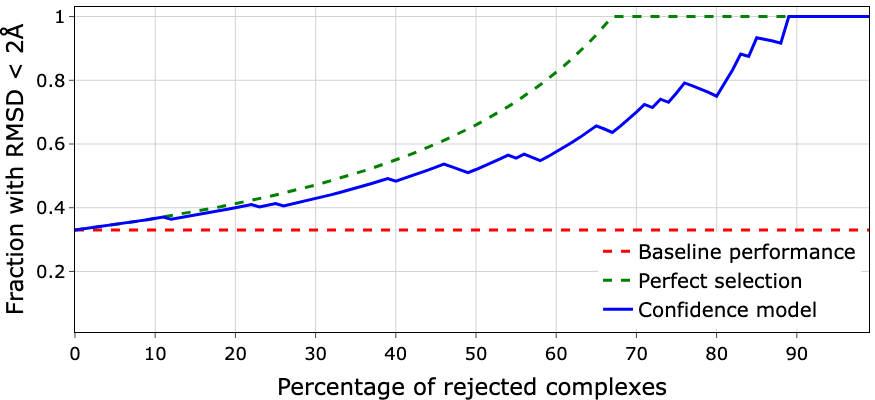

In [118]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

traces={}
traces['Baseline performance']=go.Scatter(x=list(range(100)), y=list(reversed([c/100 for c in no_calibration])), name='Baseline performance', line=dict(color='red',width=3, dash = 'dash'))
traces['Perfect selection']=go.Scatter(x=list(range(100)), y=list(reversed([c/100 for c in perfect_calibration])), name='Perfect selection', line=dict(color='green',width=3, dash = 'dash'))
traces['Confidence model']=go.Scatter(x=list(range(100)), y=list(reversed([c/100 for c in fraction_dataset_rmsds_below_2])), name='Confidence model', line=dict(color='blue',width=3))
data=list(traces.values())

# build and plot figure
fig=go.Figure(data).update_layout(xaxis_title="Percentage of rejected complexes", yaxis_title="Fraction with RMSD < 2Å", width=600, height=400,
                                 margin={'l': 60, 'r': 5, 't': 5, 'b': 60}, plot_bgcolor='white',
                paper_bgcolor='white', legend_title_text='', legend_title_font_size=1,
                legend=dict(yanchor="bottom", y=0.01, xanchor="right", x=0.99, font=dict(size=20, color='black'), ),
                )
fig.update_yaxes(range = [0.01,1.03])
fig.update_layout(margin={'l': 60, 'r': 5, 't': 5, 'b': 60}, plot_bgcolor='white',
                paper_bgcolor='white', legend_title_text='', legend_title_font_size=1,
                legend=dict(yanchor="bottom", y=0.01, xanchor="right", x=0.99, font=dict(size=20, color='black'), ),
                )
fig.update_xaxes(showgrid=True, gridcolor='lightgrey',title_font=dict(size=23, color='black'),mirror=True,ticks='outside',showline=True, linewidth=1, linecolor='black', tickfont = dict(size = 18, color='black'))
fig.update_yaxes(showgrid=True, gridcolor='lightgrey',title_font=dict(size=23, color='black'),mirror=True,ticks='outside',showline=True, linewidth=1, linecolor='black', tickfont = dict(size = 18, color='black'))
fig.write_image('../../plots/confidence_calibration.pdf')

fig.show()

### New calibration plot

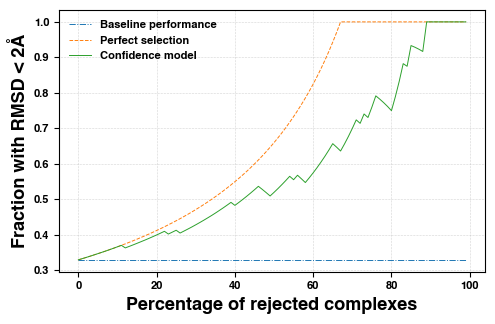

In [119]:
from matplotlib import rc
rc("text", usetex=False)
# rc("font",)

fraction = 1
xs = list(range(100))

fig,axs = plt.subplots(1, 1,figsize=set_size(width=width,fraction=fraction))  # fraction image should cover

ys = list(reversed([c/100 for c in no_calibration]))
axs.plot(xs, ys, "-.", linewidth=0.7, label='Baseline performance')

ys = list(reversed([c/100 for c in perfect_calibration]))
axs.plot(xs, ys, "--", linewidth=0.7, label = 'Perfect selection')

ys = list(reversed([c/100 for c in fraction_dataset_rmsds_below_2]))
axs.plot(xs, ys, "-", linewidth=0.7, label = 'Confidence model')

# axs.axhline(y = 1, color = 'r', linestyle = '--',linewidth=0.3)
axs.set_xlabel("Percentage of rejected complexes")
axs.set_ylabel("Fraction with RMSD < 2Å")
axs.grid(which="both",linestyle=":",linewidth=0.4)
axs.tick_params(axis='both', which='major')
# axs.spines['top'].set_visible(False)
# axs.spines['right'].set_visible(False)
axs.legend(frameon=False)
fig.savefig('../../plots/confidence_calibration_new.pdf', format='pdf', bbox_inches='tight')

### Old fraction plot

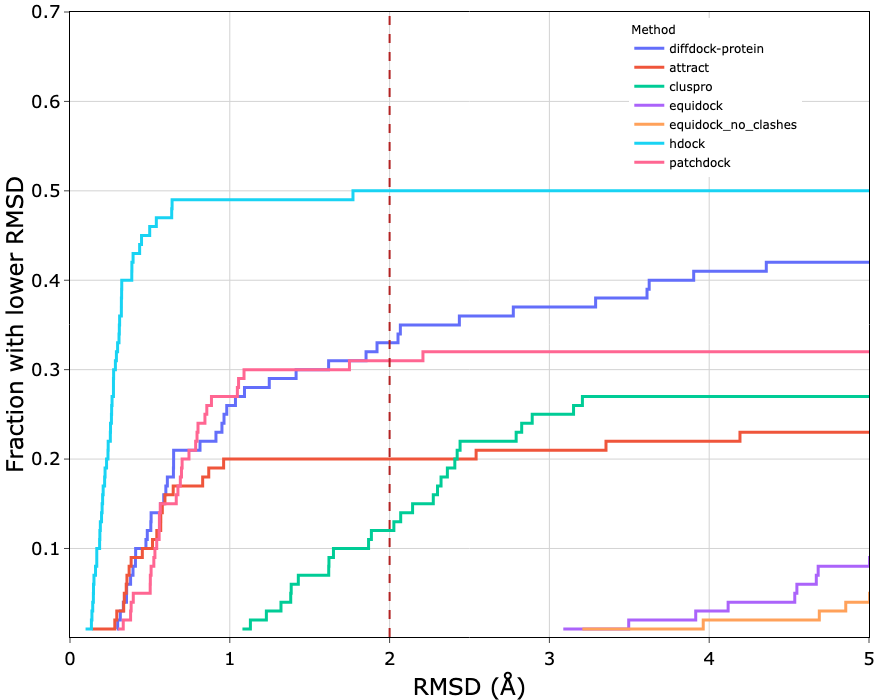

In [120]:
import plotly.express as px


fig = px.ecdf(df, range_x=[0, 5])
fig.add_vline(x=2, annotation_text='2 A', annotation_font_size=16, annotation_position="top right",
              line_dash='dash', line_color='firebrick', annotation_font_color='firebrick')
fig.update_xaxes(title=f'RMSD in Angstrom', title_font={"size": 16}, tickfont={"size": 16})
fig.update_yaxes(title=f'Fraction of predictions with lower RMSD', title_font={"size": 16},
                 tickfont={"size": 16})
fig.update_layout(autosize=False, margin={'l': 0, 'r': 0, 't': 0, 'b': 0}, plot_bgcolor='white',
                  paper_bgcolor='white', legend_title_text='Method', legend_title_font_size=12,
                  legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.7, font=dict(size=12), ), )
fig.update_xaxes(showgrid=True, gridcolor='lightgrey',title_font=dict(size=19),mirror=True,ticks='outside',showline=True,)
fig.update_yaxes(showgrid=True, gridcolor='lightgrey',title_font=dict(size=19),mirror=True,ticks='outside',showline=True,)
fig.write_image('../../plots/fraction_rmsd_old.pdf')


df = {'diffdock-protein': filtered_rmsds, "attract": attract, "cluspro": cluspro, "equidock": equidock, 
     "equidock_no_clashes": equidock_no_clashes, "hdock": hdock, "patchdock": patchdock}
fig = px.ecdf(df, range_x=[0, 5], range_y=[0.001, 0.7],  width=1000, height=700)
fig.add_vline(x=2, annotation_text='', annotation_font_size=20, annotation_position="top right",
              line_dash='dash', line_color='firebrick', annotation_font_color='firebrick')
fig.update_xaxes(title=f'RMSD (Å)')
fig.update_yaxes(title=f'Fraction with lower RMSD')
fig.update_layout(autosize=False, margin={'l': 0, 'r': 0, 't': 0, 'b': 0}, plot_bgcolor='white',
                  paper_bgcolor='white', legend_title_text='Method', legend_title_font_size=12,
                  legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.7, font=dict(size=12, color='black'), ), )
fig.update_xaxes(showgrid=True, gridcolor='lightgrey',title_font=dict(size=23, color='black'),mirror=True,ticks='outside',showline=True, linewidth=1, linecolor='black', tickfont = dict(size = 18, color='black'))
fig.update_yaxes(showgrid=True, gridcolor='lightgrey',title_font=dict(size=23, color='black'),mirror=True,ticks='outside',showline=True, linewidth=1, linecolor='black', tickfont = dict(size = 18, color='black'))
fig.update_traces(line=dict(width=3))
fig.write_image('../../plots/fraction_rmsd.pdf')
fig.show()


### New fraction plot

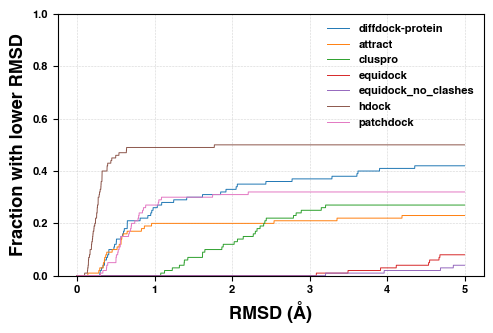

In [121]:
# from matplotlib import rc
# rc("text", usetex=False)

fraction = 1
rc("text", usetex=False)
thresholds = np.linspace(0, 5, 10000)

df = {'diffdock-protein': filtered_rmsds, "attract": attract, "cluspro": cluspro, "equidock": equidock, 
     "equidock_no_clashes": equidock_no_clashes, "hdock": hdock, "patchdock": patchdock}

fig,axs = plt.subplots(1, 1,figsize=set_size(width=width,fraction=fraction))  # fraction image should cover

for label, rmsds in df.items():
    rmsds = np.array(rmsds)
    fractions = [(rmsds < limit).mean() for limit in thresholds]
    axs.plot(thresholds, fractions, "-", linewidth=0.7, label = label)

# axs.axhline(y = 1, color = 'r', linestyle = '--',linewidth=0.3)
axs.set_xlabel('RMSD (Å)')
axs.set_ylabel('Fraction with lower RMSD')
axs.set_ylim([0.0, 1.0])
axs.grid(which="both",linestyle=":",linewidth=0.4)
axs.tick_params(axis='both', which='major')
# axs.spines['top'].set_visible(False)
# axs.spines['right'].set_visible(False)
axs.legend(frameon=False)
fig.savefig('../../plots/fraction_rmsd_new.pdf', format='pdf', bbox_inches='tight')

### Less2 Abstained Datapoints

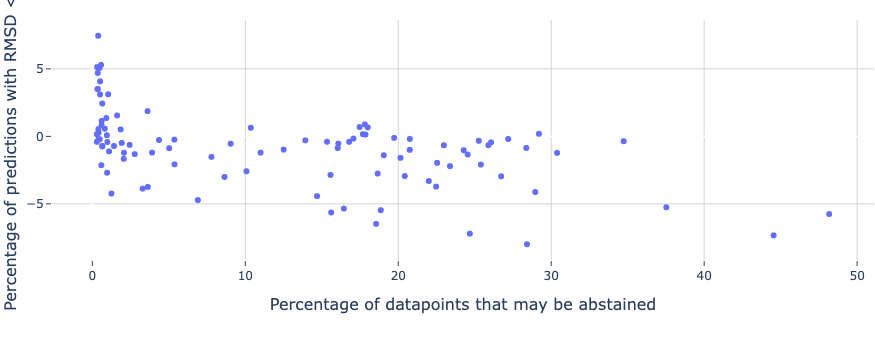

In [122]:
df = {'conf': filtered_confidences, 'rmsd': filtered_rmsds}
fig = px.scatter(df, x='rmsd',y='conf').update_layout(
    xaxis_title="Percentage of datapoints that may be abstained", yaxis_title="Percentage of predictions with RMSD < 2A"
)
fig.update_layout(margin={'l': 0, 'r': 0, 't': 20, 'b': 100}, plot_bgcolor='white',
                paper_bgcolor='white', legend_title_text='', legend_title_font_size=1,
                legend=dict(yanchor="bottom", y=0.1, xanchor="right", x=0.99, font=dict(size=17), ),
                )
fig.update_xaxes(showgrid=True, gridcolor='lightgrey',title_font=dict(size=16),mirror=True,ticks='outside',showline=True,)
fig.update_yaxes(showgrid=True, gridcolor='lightgrey',title_font=dict(size=16),mirror=True,ticks='outside',showline=True,)
fig.show()
fig.write_image('../../plots/less2_abstained_datapoints.pdf')


### Probability Rmsd

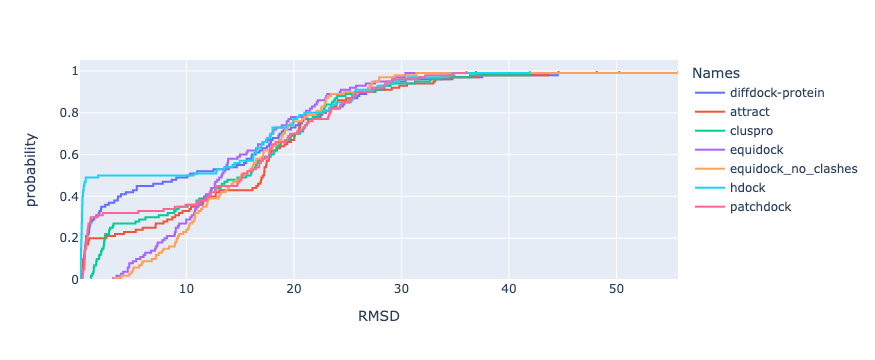

In [123]:
import pandas as pd
names = ['diffdock-protein'] * len(filtered_rmsds) + ["attract"] * len(attract) + ["cluspro"] * len(cluspro) + ["equidock"] * len(equidock) + ["equidock_no_clashes"] * len(equidock_no_clashes) + ["hdock"] * len(hdock) + ["patchdock"] * len(patchdock)
RMSD = list(filtered_rmsds) + list(attract) + list(cluspro) + list(equidock) + list(equidock_no_clashes) + list(hdock) + list(patchdock)

dfp = pd.DataFrame({'Names':names,'RMSD':RMSD})
fig = px.ecdf(dfp, x="RMSD", color="Names")
fig.write_image('../../plots/probability_rmsd.pdf')
fig.show()

### Top-n

In [124]:
def get_fraction_lower(rmsds, threshold):
    return (100 * (rmsds < threshold).sum() / len(rmsds)).__round__(2)

def shuffle_samples(rmsds, confidences, seed):
    num_graphs, max_samples = rmsds.shape
    
    np.random.seed(seed)
    
    suffled_indexes = [np.random.permutation(np.arange(max_samples)) for i in range(num_graphs)]
    shuffled_rmsds = np.take_along_axis(rmsds, np.array(suffled_indexes), axis=-1)
    shuffled_confidences = np.take_along_axis(confidences, np.array(suffled_indexes), axis=-1)
    return shuffled_rmsds, shuffled_confidences

In [125]:
threshold = 2
ideal_confidences = (rmsds < threshold) + np.random.rand(*rmsds.shape) * 10

In [126]:
# this_plot_rmsds, this_plot_confidences = all_pred_crmsd, confidences

# _, max_samples = this_plot_rmsds.shape

# np.random.seed(42)

# top_1 = []
# top_5 = []
# top_10 = []
# perfect = []

# threshold = 2
# n_repetitions = 1000

# rmsds_repeated = np.repeat(this_plot_rmsds, n_repetitions, axis=0)
# confidences_repeated = np.repeat(this_plot_confidences, n_repetitions, axis=0)

# print(rmsds_repeated.shape, confidences_repeated.shape)

# n_of_generated_samples = list(range(1, max_samples+1))
# for n_samples in n_of_generated_samples:
#     shuffled_rmsds, shuffled_confidences = shuffle_samples(rmsds_repeated, confidences_repeated, seed=n_samples)
    
#     rmsds_current = shuffled_rmsds[:, :n_samples]
#     confidences_current = shuffled_confidences[:, :n_samples]
    
#     sorted_indexes_ascending = np.argsort(confidences_current, axis=-1)
#     sorted_indexes = np.flip(sorted_indexes_ascending, axis=-1)
    
    
#     rmsds_sorted_by_confidences = np.take_along_axis(rmsds_current, sorted_indexes, axis=-1)    
    
#     top_1.append(get_fraction_lower(rmsds_sorted_by_confidences[:, :1].min(axis=-1), threshold))
#     top_5.append(get_fraction_lower(rmsds_sorted_by_confidences[:, :5].min(axis=-1), threshold))
#     top_10.append(get_fraction_lower(rmsds_sorted_by_confidences[:, :10].min(axis=-1), threshold))
#     perfect.append(get_fraction_lower(rmsds_sorted_by_confidences.min(axis=-1), threshold))

In [127]:
width

397.48499

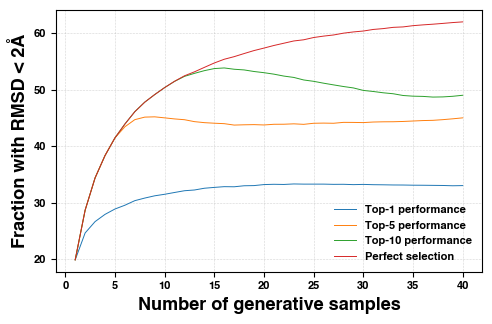

In [128]:
fig,axs = plt.subplots(1, 1,figsize=set_size(width=width,fraction=fraction))  # fraction image should cover

# axs.axhline(y = 1, color = 'r', linestyle = '--',linewidth=0.3)

axs.plot(n_of_generated_samples, top_1, "-", linewidth=0.7, label="Top-1 performance")
axs.plot(n_of_generated_samples, top_5, "-", linewidth=0.7, label="Top-5 performance")
axs.plot(n_of_generated_samples, top_10, "-", linewidth=0.7, label="Top-10 performance")
axs.plot(n_of_generated_samples, perfect, "-", linewidth=0.7, label="Perfect selection")

axs.set_xlabel("Number of generative samples")
axs.set_ylabel(f"Fraction with RMSD < {threshold}Å")
axs.grid(which="both",linestyle=":",linewidth=0.4)
axs.tick_params(axis='both', which='major')
# axs.spines['top'].set_visible(False)
# axs.spines['right'].set_visible(False)
axs.legend(frameon=False)

fig.savefig(f"../../plots/top-n-samples-rmsd-{threshold}_new.pdf", format='pdf', bbox_inches='tight')